In [71]:
using SpecialFunctions  # Importing the required module for arccos function
using DifferentialEquations
using LinearAlgebra
using Combinatorics
using SymEngine
using Polynomials
using NLsolve
using Plots
using PlotlyJS
using LaTeXStrings
using TensorOperations
using Random

# using DynamicalSystems

In [72]:
import Statistics

In [73]:
function levi_cevita_tensor(dim)
    arr = zeros(Int, tuple(fill(dim, dim)...))
    for x in permutations(1:dim)
        mat = zeros(Int, (dim, dim))
        for (i, j) in enumerate(x)
            mat[i, j] = 1
        end
        arr[x...] = det(mat)
    end
    return arr
end

levi_cevita_tensor (generic function with 1 method)

In [74]:
function get_norm(T, g)
    """
    T should have configuration either 'u' or 'uu'
    """
    if ndims(T) == 2
        @tensor begin
            D[] := g[u,a]*T[v,b]*T[a,b]
        end
        # return ein"(ua,vb,ab),uv->"(g,T,T)
        return D
    else
        @tensor begin
            D[] := g[a,b]*T[b]*T[a]
        end
        # return ein"(ab,b),a->"(g,T,T)
        return D
    end
end

get_norm (generic function with 1 method)

In [75]:
function metric_tensor(r, theta, a, M=1,cpx=0)
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: ll
    """
    g = [
        [
            (-(a^2) + 2 * M * r - r^2 + a^2 * sin(theta)^2) / (r^2 + a^2 * cos(theta)^2),
            0,
            0,
            -((2 * a * M * r * sin(theta)^2) / (r^2 + a^2 * cos(theta)^2)),
        ],
        [
            0,
            (r^2 + a^2 * cos(theta)^2) / (a^2 - 2 * M * r + r^2),
            0,
            0,
        ],
        [0, 0, r^2 + a^2 * cos(theta)^2, 0],
        [
            -((2 * a * M * r * sin(theta)^2) / (r^2 + a^2 * cos(theta)^2)),
            0,
            0,
            (
                sin(theta)^2 * ((a^2 + r^2)^2 - a^2 * (a^2 - 2 * M * r + r^2) * sin(theta)^2)
            ) / (r^2 + a^2 * cos(theta)^2),
        ],
    ]

    if cpx==1
        g=ComplexF64.(stack(g))
        return g
    end
    return stack(g)
end


metric_tensor (generic function with 3 methods)

In [76]:
function antisymmetrize(arr)
    #* Function to antisymmetrize matrix
    arr = permutedims(arr, (1, 2,4,3))
    anti_arr = arr - permutedims(arr, (1,2, 4,3))
    anti_tensor = permutedims(anti_arr, (1,2, 4,3))
    return anti_tensor
end


antisymmetrize (generic function with 1 method)

In [77]:
function symmetrize(arr)
    """
    Symmetrizes a 4-dimensional Julia array along last two axes.

    Args:
        arr (Array): The input array.

    Returns:
        Array: The symmetrized array.

    Example:

        arr = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]

        result = symmetrize(arr)
        display(result)
    """

    toput = permutedims(stack([arr[:, i, i] for i in range(1, 4)]),(2,1))
    de_ = zeros(Float64, 4, 4, 4)

    [de_[:, i, i] .= toput[i, :] for i in range(1, 4)]

    return arr + permutedims(arr, (1, 3, 2)) - de_
end


symmetrize (generic function with 1 method)

In [78]:
function kerr_christoffel(r, theta, a, M=1,cpx=0)
    """
    Function to give the Christoffel symbols for the Kerr metric.
    The Christoffel symbols are given as Gamma ^i _{jk}

    From Reference Paper, Appendix
    Config: ull
    """
    if cpx==1
        cs = zeros(ComplexF64,4, 4, 4)
    else
        cs=zeros(4,4,4)
    end

    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    scA = (r^2 + a^2)^2 - Delta * a^2 * sin(theta)^2
    omega_k = 2 * M * a * r / scA
    Sigma = r^2 + a^2 * cos(theta)^2

    cs[4, 1, 2] = M * (2 * r^2 - Sigma) / (Delta * Sigma^2) * a
    cs[1, 1, 2] = cs[4, 1, 2] * (r^2 + a^2) / a

    cs[4, 1, 3] = -2 * M * a * r / (tan(theta) * Sigma^2)
    cs[1, 1, 3] = a * sin(theta)^2 * cs[4, 1, 3]

    cs[1, 2, 4] = (
        -M
        * a
        * (2 * r^2 * (r^2 + a^2) + Sigma * (r^2 - a^2))
        * sin(theta)^2
        /
        (Delta * Sigma^2)
    )

    cs[4, 2, 4] = (
        r * Sigma * (Sigma - 2 * M * r)
        -
        M * a^2 * (2 * r^2 - Sigma) * sin(theta)^2
    ) / (Delta * Sigma^2)

    cs[1, 3, 4] = M * a^3 * r * sin(theta)^2 * sin(2 * theta) / Sigma^2

    cs[4, 3, 4] = (scA - Sigma * a^2 * sin(theta)^2) / (tan(theta) * Sigma^2)

    cs[2, 1, 1] = M * Delta * (2 * r^2 - Sigma) / Sigma^3

    cs[2, 1, 4] = -cs[2, 1, 1] * a * sin(theta)^2

    cs[3, 1, 1] = -M * a * r * sin(2 * theta) / Sigma^3 * a
    cs[3, 1, 4] = -cs[3, 1, 1] * (r^2 + a^2) / a

    cs[2, 2, 2] = r / Sigma + (M - r) / Delta

    cs[2, 3, 3] = -r * Delta / Sigma
    cs[3, 2, 3] = -cs[2, 3, 3] / Delta

    cs[2, 2, 3] = cs[3, 3, 3] = -(a^2) * sin(2 * theta) / (2 * Sigma)
    cs[3, 2, 2] = -cs[2, 2, 3] / Delta

    cs[2, 4, 4] = (
        -Delta
        * (r * Sigma^2 - M * a^2 * (2 * r^2 - Sigma) * sin(theta)^2)
        * sin(theta)^2
        /
        Sigma^3
    )

    cs[3, 4, 4] = (
        -(Delta * Sigma^2 + 2 * M * r * (r^2 + a^2)^2)
        *
        sin(2 * theta)
        /
        (2 * Sigma^3)
    )

    return symmetrize(cs)
end


kerr_christoffel (generic function with 3 methods)

In [79]:
function kerr_riemann_tensor(r, theta, a, M=1, config="ulll",cpx=0)
    # Define variables

    if cpx==1
        rijkl = zeros(ComplexF64,4, 4, 4, 4)
    else
        rijkl = zeros(4, 4, 4, 4)
    end
    # Q = zeros(4,4,4,4)

    X = r^2 - 3 * a^2 * cos(theta)^2
    Y = 3 * r^2 - a^2 * cos(theta)^2

    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    scA = (r^2 + a^2)^2 - Delta * a^2 * sin(theta)^2
    omega_k = 2 * M * a * r / scA
    Sigma = r^2 + a^2 * cos(theta)^2

    rijkl[1, 1, 1, 4] = 2 * M^2 * a * r^2 * X * sin(theta)^2 / Sigma^4
    rijkl[4, 4, 1, 4] = -rijkl[1, 1, 1, 4]
    rijkl[1, 4, 1, 4] = -rijkl[1, 1, 1, 4] / omega_k
    rijkl[4, 1, 1, 4] = -rijkl[1, 1, 1, 4] / (2 * M * a * r / (Delta - a^2 * sin(theta)^2))

    rijkl[1, 1, 2, 3] = -(
        M^2 * a^2 * r * Y * sin(2 * theta) / (Delta * Sigma^3)
    )
    rijkl[4, 4, 2, 3] = -rijkl[1, 1, 2, 3]
    rijkl[1, 4, 2, 3] = -rijkl[1, 1, 2, 3] / omega_k
    rijkl[4, 1, 2, 3] = -rijkl[1, 1, 2, 3] / (2 * M * a * r / (Delta - a^2 * sin(theta)^2))

    rijkl[4, 3, 3, 4] = -(
        M * r * X * (2 * (r^2 + a^2) + a^2 * sin(theta)^2) / Sigma^3
    )

    rijkl[1, 2, 1, 2] = -rijkl[4, 3, 3, 4] / Delta

    rijkl[1, 3, 1, 3] = -(
        M * r * X * ((r^2 + a^2) + 2 * a^2 * sin(theta)^2) / Sigma^3
    )

    rijkl[4, 2, 2, 4] = -rijkl[1, 3, 1, 3] / Delta

    rijkl[1, 2, 1, 3] = rijkl[4, 3, 1, 4] = (
        -M
        *
        a^2
        /
        (Delta * Sigma^3)
        * Y
        * (3 * (r^2 + a^2) - 2 * M * r)
        * sin(theta)
        * cos(theta)
    )

    rijkl[1, 3, 1, 2] = rijkl[4, 3, 1, 4] = (
        -M
        *
        a^2
        /
        (Delta * Sigma^3)
        * Y
        * (3 * (r^2 + a^2) - 4 * M * r)
        * sin(theta)
        * cos(theta)
    )

    rijkl[4, 3, 1, 3] = -3 * M * a * r * X / Sigma^3
    rijkl[4, 2, 1, 2] = -rijkl[4, 3, 1, 3] / Delta

    rijkl[1, 3, 3, 4] = rijkl[4, 3, 1, 3] * sin(theta)^2 * (r^2 + a^2)
    rijkl[1, 2, 2, 4] = -rijkl[1, 3, 3, 4] / Delta

    rijkl[2, 1, 1, 3] = (
        -3 * M * a^2 * Delta / Sigma^4 * Y * sin(theta) * cos(theta)
    )
    rijkl[3, 1, 1, 2] = rijkl[2, 1, 1, 3] / Delta

    rijkl[2, 1, 2, 4] = (
        M
        * a
        * r
        /
        Sigma^4
        * X
        * sin(theta)^2
        * (3 * (r^2 + a^2) - 4 * M * r)
    )
    rijkl[2, 4, 1, 2] = -rijkl[2, 1, 2, 4]

    rijkl[3, 1, 3, 4] = -(
        M
        * a
        * r
        /
        Sigma^4
        * X
        * sin(theta)^2
        * (3 * (r^2 + a^2) - 2 * M * r)
    )

    rijkl[3, 4, 1, 3] = -rijkl[3, 1, 3, 4]

    rijkl[2, 1, 1, 4] = (
        -M
        * a
        * Delta
        /
        Sigma^4
        * Y
        * sin(theta)
        * cos(theta)
        * (2 * (r^2 + a^2) + a^2 * sin(theta)^2)
    )
    rijkl[3, 4, 1, 2] = -rijkl[2, 1, 1, 4] / Delta

    rijkl[2, 4, 1, 3] = (
        M
        * a
        * Delta
        /
        Sigma^4
        * Y
        * sin(theta)
        * cos(theta)
        * ((r^2 + a^2) + 2 * a^2 * sin(theta)^2)
    )

    rijkl[3, 1, 2, 4] = -rijkl[2, 4, 1, 3] / Delta

    rijkl[2, 3, 1, 4] = Delta^2 * rijkl[1, 1, 2, 3] / (2 * M * a * r)
    rijkl[3, 2, 1, 4] = -rijkl[2, 3, 1, 4] / Delta

    rijkl[2, 4, 3, 4] = -(r^2 + a^2) * sin(theta)^2 * rijkl[2, 1, 1, 3]
    rijkl[3, 4, 2, 4] = rijkl[2, 4, 3, 4] / Delta

    rijkl[2, 3, 2, 3] = -M * r * X / Sigma^2
    rijkl[3, 2, 2, 3] = -rijkl[2, 3, 2, 3] / Delta

    rijkl[1, 2, 3, 4] = (
        -M
        * a
        * Y
        * (2 * (r^2 + a^2)^2 + Delta * a^2 * sin(theta)^2)
        * sin(theta)
        * cos(theta)
        /
        (Delta * Sigma^3)
    )
    rijkl[1, 3, 2, 4] = (
        -M
        * a
        * Y
        * ((r^2 + a^2)^2 + 2 * Delta * a^2 * sin(theta)^2)
        * sin(theta)
        * cos(theta)
        /
        (Delta * Sigma^3)
    )

    rijkl[4, 2, 1, 3] = (
        -M
        * a
        * Y
        * (Delta + 2 * a^2 * sin(theta)^2)
        /
        (tan(theta) * Delta * Sigma^3)
    )
    rijkl[4, 3, 1, 2] = (
        -M
        * a
        * Y
        * (2 * Delta + a^2 * sin(theta)^2)
        /
        (tan(theta) * Delta * Sigma^3)
    )

    rijkl[2, 1, 1, 2] = (
        M * r * X * (2 * Delta + a^2 * sin(theta)^2) / Sigma^4
    )

    rijkl[3, 1, 1, 3] = -(
        M * r * X * (Delta + 2 * a^2 * sin(theta)^2) / Sigma^4
    )

    rijkl[2, 4, 2, 4] = (
        -M * r * X * ((r^2 + a^2)^2 + 2 * Delta * a^2 * sin(theta)^2)*sin(theta)^2 / Sigma^4
    )
    rijkl[3, 4, 3, 4] = (
        M * r * X * (2 * (r^2 + a^2)^2 + Delta * a^2 * sin(theta)^2)*sin(theta)^2 / Sigma^4
    )

    gk = metric_tensor(r, theta, a, M,cpx)

    if config == "ulll"
        return antisymmetrize(rijkl)
    elseif config == "llll"
        rulll = antisymmetrize(rijkl)
        # return ein"ij,jklm->iklm"(gk, rulll)
        @tensor begin
            E[i,k,l,m] := gk[i,j]*rulll[j,k,l,m]
        end
        return E
    else
        # Config: lluu
        # gkinv = inv(metric_tensor(r, theta, a, M,cpx))
        gkinv=inv(gk)
        # rllll = antisymmetrize(
        #     ein"ij,jklm->iklm"(gk, rijkl)
        # )
        @tensor begin
            E[i,k,l,m] :=gk[i,j]*rijkl[j,k,l,m]
        end
        rllll=antisymmetrize(E)
        # return ein"kjlm,al,bm->kjab"(rllll, gkinv, gkinv)

        @tensor begin
            F[k,j,a,b] := rllll[k,j,l,m]*gkinv[a,l]*gkinv[b,m]
        end
        return F
    end
end


kerr_riemann_tensor (generic function with 4 methods)

In [80]:

function spin_matrix(sa, pb, gk, epsilon)
    # Resultant Config: aa
    # Input Config: u,u,uu,llll
    # In Tetrad Basis or Coordinate basis
    gkinv = inv(gk)
    # return ein"(ab,cd,bdkl,l),k -> ac"(gkinv, gkinv, epsilon, sa, pb)
    @tensor begin
        E[a,c] := gkinv[a,b]*gkinv[c,d]*epsilon[b,d,k,l]*sa[l]*pb[k]
    end
    return E*0.5
end


spin_matrix (generic function with 1 method)

In [81]:
function get_dual(r, theta, a, epsilon, config="lluu", M=1,cpx=0)
    # Eq 5.28 Format
    # Q=zeros(4,4,4,4)
    rijkl = kerr_riemann_tensor(r, theta, a, M, config,cpx)
    # return ein"ijkl,klmn->ijmn"( rijkl, epsilon )* 0.5
    @tensor begin
        E[i,j,m,n]:=rijkl[i,j,k,l]*epsilon[k,l,m,n]
    end
    return E*0.5
end


get_dual (generic function with 4 methods)

In [82]:
function get_dual_dual(r, theta, a, gk, epsilon, M=1,cpx=0)
    # Eq 5.31 Format
    gkinv = inv(gk)
    # Q=zeros(4,4,4,4)
    drijkl = get_dual(r, theta, a, epsilon,"lluu", M,cpx)
    # Config: llll
    # sdrijkl = ein"ij,kl,jlps->ikps"(gkinv, gkinv, drijkl)  # Config: uull
    @tensor begin
        sdrijkl[i,k,p,s]:=gkinv[i,j]*gkinv[k,l]*drijkl[j,l,p,s]
    end
    # return ein"uvab,abps->uvps"(epsilon,sdrijkl)* 0.5
    @tensor begin
        E[u,v,p,s]:=epsilon[u,v,a,b]*sdrijkl[a,b,p,s]
    end
    return E*0.5
end

get_dual_dual (generic function with 3 methods)

In [83]:
function to_cartesian(rsol)
    r, t, p = rsol[2], rsol[3], rsol[4]
    vr,vt,vp= rsol[5],rsol[6],rsol[7]

    x = r .* sin(t) .* cos(p)
    y = r .* sin(t) .* sin(p)
    z = r .* cos(t)

    vx = vr .* sin(vt) .* cos(vp)
    vy = vr .* sin(vt) .* sin(vp)
    vz=vr.*cos(vt)

    return hcat(x, y, z),hcat(vx,vy,vz)
end


to_cartesian (generic function with 1 method)

In [84]:
function rhs23(y, vmu, sp, ps, gk, epsilon, a, M=1.0,cpx=0)
    _, r, theta, _ = y
    # Q1=zeros(4,4,4,4)
    # Q2=zeros(4)
    gkinv = inv(gk)
    drijkl = get_dual(r, theta, a, epsilon, M,cpx)
    # sdrijkl = ein"ua,avps->uvps"(gkinv, drijkl)  # Config: uull
    @tensor begin
        sdrijkl[u,v,p,s] :=gkinv[u,a]*drijkl[a,v,p,s]
    end
    
    cs = kerr_christoffel(r, theta, a, M,cpx)

    # term1 = ein"uvps,v,p,s->u"(sdrijkl, vmu, sp,ps) / m
    @tensor begin
        term1[u] := sdrijkl[u,v,p,s]*vmu[v]*sp[p]*ps[s]/m 
    end


    # term2 = ein"usp,p,s->u"(cs, ps, ps) / m
    @tensor begin
        term2[u] := cs[u,s,p]*ps[p]*ps[s]/m
    end

    return term1 - term2
end


rhs23 (generic function with 3 methods)

In [85]:
function rhs24(y, vmu, sp, ps, epsilon, a, M=1.0,cpx=0)
    _, r, theta, _ = y
    # Q=zeros(4)
    drijkl = get_dual(r, theta, a, epsilon, M,cpx)
    cs = kerr_christoffel(r, theta, a, M,cpx)

    # term1 = ein"u,vpsg,v,p,s,g->u"(ps, drijkl, sp, vmu, sp,ps) / (m^3)
    @tensor begin
        term1[u] := ps[u]*drijkl[v,p,s,g]*sp[v]*vmu[p]*sp[s]*ps[g]/(m^3)
    end

    # term2 = ein"usp,p,s->u"(cs, ps,sp) / m
    @tensor begin
        term2[u] := cs[u,s,p]*ps[p]*sp[s]/m
    end

    return term1 - term2
end


rhs24 (generic function with 3 methods)

In [86]:
function rhs27(y, umu, su, gk, eps, a, m, config="l", M=1,cpx=0)
    _, r, theta, _ = y
    gkinv = inv(gk)
    ddrijkl = get_dual_dual(r, theta, a, gk, eps, M,cpx)
    # Q1=zeros(4,4,4,4)
    # Q2=zeros(4)

    if config == "l"
        # Umu is u_mu
        # term2 = ein"uvps,v,p,sj,j->u"(ddrijkl, su, su, gkinv,umu)/ m^2
        @tensor begin
            term2[u] := ddrijkl[u,v,p,s]*su[v]*su[p]*gkinv[s,j]*umu[j]/m^2
        end
        return umu + term2
    else
        # Umu is u^mu
        # sddrijkl = ein"ab,bvps->avps"(gkinv,ddrijkl) # Config: uull
        @tensor begin
            sddrijkl[a,v,p,s]:=gkinv[a,b]*ddrijkl[b,v,p,s]
        end

        # term2 = ein"avps,v,p,s->a"(sddrijkl, su ,su,umu)/m^2
        @tensor begin
            term2[a] := sddrijkl[a,v,p,s]*su[v]*su[p]*umu[s]/m^2
        end
        return umu + term2
    end
end


rhs27 (generic function with 4 methods)

In [87]:
function mpd!(dy, y, p, t)
    """
    Solve the MPD Equations Given the Initial Conditions
    """
    ps = y[5:8]
    su = y[9:end]
    a, m, M ,cpx= p

    gk = metric_tensor(y[2], y[3], a, M,cpx)

    eps = levi_cevita_tensor(4)

    vmu = rhs27(y[1:4], ps / m, su, gk, eps, a, m, "u", M,cpx)

    dy[1:4] .= vmu

    dy[5:8] .= rhs23(y[1:4], vmu, su, ps, gk, eps, a, M,cpx)
    dy[9:end] .= rhs24(y[1:4], vmu, su, ps, eps, a, M,cpx)
    return nothing
end

mpd! (generic function with 1 method)

In [88]:
function mpd(t,y, p)
    """
    Solve the MPD Equations Given the Initial Conditions
    """
    dy=zeros(length(y))
    ps = y[5:8]
    su = y[9:end]
    a, m, M, cpx = p

    gk = metric_tensor(y[2], y[3], a, M, cpx)

    eps = levi_cevita_tensor(4)

    vmu = rhs27(y[1:4], ps / m, su, gk, eps, a, m, "u", M, cpx)

    dy[1:4] .= vmu

    dy[5:8] .= rhs23(y[1:4], vmu, su, ps, gk, eps, a, M, cpx)
    dy[9:end] .= rhs24(y[1:4], vmu, su, ps, eps, a, M, cpx)
    return dy
end

mpd (generic function with 1 method)

In [89]:
M = 1.0
m = 1e-6

S = 1.0 * m * M
E = 0.9328 * m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = pi / 2
phi0 = 0.0
a0 = 0.8 

S1 = 0.0
S3 = 0.0

P2 = 0.0

0.0

In [90]:
gk=metric_tensor(r0,theta0,a0,M,1)

4×4 Matrix{ComplexF64}:
 -0.666667+0.0im      0.0+0.0im   0.0+0.0im  -0.266667+0.0im
       0.0+0.0im  1.46104+0.0im   0.0+0.0im        0.0+0.0im
       0.0+0.0im      0.0+0.0im  36.0+0.0im        0.0+0.0im
 -0.266667+0.0im      0.0+0.0im   0.0+0.0im    36.8533+0.0im

In [91]:
cs=kerr_christoffel(r0,theta0,a0,M,0);

In [92]:
@vars p0 p1 p3

(p0, p1, p3)

In [93]:
Pi=[p0,p1,P2,p3]

4-element Vector{Basic}:
  p0
  p1
 0.0
  p3

In [94]:
# Definitions
Delta = a0^2 - 2 * M * r0 + r0^2
scA = (r0^2 + a0^2)^2 - Delta * a0^2 * sin(theta0)^2
omega_k = 2 * M * a0 * r0 / scA
Sigma = r0^2 + a0^2 * cos(theta0)^2

36.0

In [95]:
Suin=[0.0,S1,-S,S3]

4-element Vector{Float64}:
  0.0
  0.0
 -1.0e-6
  0.0

In [96]:
epsl=levi_cevita_tensor(4);

In [97]:
eta = [-1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]

4×4 Matrix{Float64}:
 -1.0  0.0  0.0  0.0
  0.0  1.0  0.0  0.0
  0.0  0.0  1.0  0.0
  0.0  0.0  0.0  1.0

In [98]:
gkinv=inv(gk)

4×4 Matrix{ComplexF64}:
   -1.49567+0.0im       0.0+0.0im        0.0-0.0im  -0.0108225-0.0im
        0.0+0.0im  0.684444-0.0im        0.0-0.0im        -0.0-0.0im
        0.0+0.0im       0.0+0.0im  0.0277778-0.0im        -0.0-0.0im
 -0.0108225+0.0im       0.0+0.0im        0.0+0.0im   0.0270563-0.0im

In [99]:
Sab=spin_matrix(Suin,Pi,eta,epsl)

4×4 Matrix{Basic}:
         0  -5e-07*p3  0  5e-07*p1
  5e-07*p3          0  0  5e-07*p0
         0          0  0         0
 -5e-07*p1  -5e-07*p0  0         0

In [100]:
eq210a = sqrt(Delta / Sigma) * Pi[1] + a0 / sqrt(Sigma) * sin(theta0) * Pi[4] +
         M / Sigma^2 * (r0^2 - a0^2 * cos(theta0)^2) * Sab[2, 1] +
         2 * M * r0 * a0 * cos(theta0) / Sigma^2 * Sab[3, 4] - E


-9.328e-07 + 0.82731157639939*p0 + 0.133333347222222*p3

In [101]:
eq210b = a0 * sin(theta0)^2 * sqrt(Delta / Sigma) * Pi[1] +
         (r0^2 + a0^2) * sin(theta0) / sqrt(Sigma) * Pi[4] +
         a0 * ((r0 - M) * Sigma + 2 * M * r0^2) / Sigma^2 * sin(theta0)^2 * Sab[2, 1] +
         a0 * sqrt(Delta) * sin(theta0) * cos(theta0) * Sab[3, 1] / Sigma +
         ((r0^2 + a0^2)^2 - a0^2 * Delta * sin(theta0)^2) * cos(theta0) * Sab[3, 4] / Sigma^2 +
         r0 * sqrt(Delta) * sin(theta0) * Sab[2, 4] / Sigma - Jz


-2.8e-06 + 0.661849674775301*p0 + 6.10666674444444*p3

In [102]:
eq533=get_norm(Pi,eta)[1]+m^2

1e-12 - 1.0*p0^2 + 1.0*p1^2 + 1.0*p3^2

In [103]:
feq533=lambdify(eq533,[p0,p1,p3])

#36 (generic function with 1 method)

In [104]:
feq210a = lambdify(eq210a, [p0, p1, p3])
feq210b = lambdify(eq210b, [p0, p1, p3])

#36 (generic function with 1 method)

In [105]:
function solve_eq(p)
    [feq210a(p[1],p[2],p[3]),
        feq210b(p[1], p[2], p[3]),
        feq533(p[1], p[2], p[3])]
    
end

solve_eq (generic function with 1 method)

In [106]:
sol=nlsolve(solve_eq,[0.,0.,0.])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0, 0.0]
 * Zero: [1.0723419323592016e-6, 0.0, 3.422932556000003e-7]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 2

In [107]:
sol.zero

3-element Vector{Float64}:
 1.0723419323592016e-6
 0.0
 3.422932556000003e-7

In [108]:
feq210b(sol.zero...)

-8.470329472543003e-22

In [109]:
get_norm([sol.zero[1],sol.zero[2],0.,sol.zero[3]],eta)

0-dimensional Array{Float64, 0}:
-1.0327525470666193e-12

In [110]:
function co_tat(r, theta, a, vec, method="to")
    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    scA = (r^2 + a^2)^2 - Delta * a^2 * sin(theta)^2
    omega_k = 2 * M * a * r / scA
    Sigma = r^2 + a^2 * cos(theta)^2

    e0 = [sqrt(Delta / Sigma), 0.0, 0.0, -a * sin(theta)^2 * sqrt(Delta / Sigma)]

    e1 = [0.0, sqrt(Sigma / Delta), 0.0, 0.0]
    e2 = [0.0, 0.0, sqrt(Sigma), 0.0]
    e3 = [-a * sin(theta) / sqrt(Sigma), 0.0, 0.0, (r^2 + a^2) * sin(theta) / sqrt(Sigma)]

    tet = hcat(e0, e1, e2, e3)

    # Now for tetrad to Coordinate basis
    tet_inv = inv(tet)

    if method == "to"
        if ndims(vec) == 1
            # return ein"ij,i->j"(tet , vec)
            @tensor begin
                E[j]:=tet[i,j]*vec[i]
            end
            return E
        else
            # return ein"ij,kl,ik->jl"(tet, tet , vec)
            @tensor begin
                E[j,l]:=tet[i,j]*tet[k,l]*vec[i,k]
            end
            return E
        end
    elseif method == "from"
        if ndims(vec) == 1
            # return ein"ij,i->j"(tet_inv , vec)
            @tensor begin
                E[j]:=tet_inv[i,j]*vec[i]
            end
        else
            # return ein"ij,kl,ik->jl"(tet_inv , tet_inv , vec)
            @tensor begin
                E[j,l]:=tet_inv[i,j]*tet_inv[k,l]*vec[i,k]
            end
            return E
        end
    end
end


co_tat (generic function with 2 methods)

In [111]:
Pi=[sol.zero[1],sol.zero[2],0.,sol.zero[3]]

4-element Vector{Float64}:
 1.0723419323592016e-6
 0.0
 0.0
 3.422932556000003e-7

In [112]:
p_coordu=co_tat(r0,theta0,a0,Pi,"from")

4-element Vector{Float64}:
 1.3648588724371242e-6
 0.0
 0.0
 8.585280107941324e-8

In [113]:
get_norm(p_coordu,gk)

0-dimensional Array{ComplexF64, 0}:
-1.0327525470666195e-12 + 0.0im

In [114]:
sinl=[0.,0.,-S,0.]

4-element Vector{Float64}:
  0.0
  0.0
 -1.0e-6
  0.0

In [115]:
s_coordu=co_tat(r0,theta0,a0,sinl,"from")

4-element Vector{Float64}:
  0.0
  0.0
 -1.6666666666666665e-7
  0.0

In [116]:
get_norm(s_coordu,gk)

0-dimensional Array{ComplexF64, 0}:
9.999999999999998e-13 + 0.0im

In [117]:
vmu0 = rhs27([0.0, r0, theta0, phi0], p_coordu / m, s_coordu, gk, epsl, a0, m, "u", M,1)

4-element Vector{ComplexF64}:
   1.364854485928886 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
 0.08585310576986649 + 0.0im

In [118]:
function get_constants(rsol, eta, gk, a=a0, M=1)
    _, r, theta, _ = rsol[1:4]
    pmuu = rsol[5:8]
    smuu = rsol[9:end]

    Pi = co_tat(r, theta, a, pmuu, "to")  # 'u', tetrad
    si = co_tat(r, theta, a, smuu, "to")  # 'u', tetrad

    epsilon = levi_cevita_tensor(4)  # 'llll', tetrad
    Sab = spin_matrix(si, Pi, eta, epsilon)

    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    scA = (r^2 + a^2)^2 - Delta * a^2 * sin(theta)^2
    omega_k = 2 * M * a * r / scA
    Sigma = r^2 + a^2 * cos(theta)^2

    E = sqrt(Delta / Sigma) * Pi[1] +
        a / sqrt(Sigma) * sin(theta) * Pi[4] +
        M / Sigma^2 * (r^2 - a^2 * cos(theta)^2) * Sab[2, 1] +
        2 * M * r * a * cos(theta) / Sigma^2 * Sab[3, 4]

    Jz = a * sin(theta)^2 * sqrt(Delta / Sigma) * Pi[1] +
         (r^2 + a^2) * sin(theta) / sqrt(Sigma) * Pi[4] +
         a * ((r - M) * Sigma + 2 * M * r^2) / Sigma^2 * sin(theta)^2 * Sab[2, 1] +
         a * sqrt(Delta) * sin(theta) * cos(theta) * Sab[3, 1] / Sigma +
         ((r^2 + a^2)^2 - a^2 * Delta * sin(theta)^2) * cos(theta) * Sab[3, 4] / Sigma^2 +
         r * sqrt(Delta) * sin(theta) * Sab[2, 4] / Sigma

    mu = get_norm(Pi, eta)[1]
    Smag = get_norm(si, eta)[1]

    return E, Jz, mu, Smag
end


get_constants (generic function with 3 methods)

In [119]:
y0 =[0.0, r0, theta0, phi0, p_coordu[1], p_coordu[2], p_coordu[3], p_coordu[4], s_coordu[1], s_coordu[2], s_coordu[3], s_coordu[4]];

In [120]:
get_constants(y0,eta,gk,a0,M)

(9.327999999999994e-7, 2.7999999999999986e-6, -1.0327525470666193e-12, 1.0e-12)

In [121]:
t=0.:20.0:100000;
t_span=(0.0,100.0)

(0.0, 100.0)

In [122]:
p=[a0,m,M,1.0]

4-element Vector{Float64}:
 0.8
 1.0e-6
 1.0
 1.0

In [123]:
f! = ODEFunction(mpd!);
prob = ODEProblem(mpd!, y0, t_span,p);

In [124]:
sol = solve(prob, reltol=1e-15, abstol=1e-15, maxiters=1e6);

In [125]:
energy = map(x -> get_constants(x,eta,gk,a0,M),sol.u);

In [126]:
@show ΔE = energy[1][2] - energy[end][2]

ΔE = (energy[1])[2] - (energy[end])[2] = 5.834236334672995e-13


5.834236334672995e-13

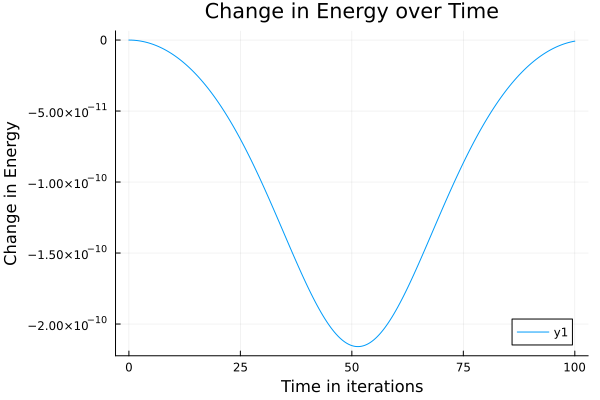

In [127]:
#Plot
Plots.plot(sol.t, [energy[i][1] - energy[1][1] for i in range(1, length(sol.u))], title="Change in Energy over Time",
    xaxis="Time in iterations", yaxis="Change in Energy")

In [128]:
corbit=map(x->to_cartesian(x),sol.u);

In [129]:
xcorbit= [corbit[i][1] for i in 1:length(corbit)];

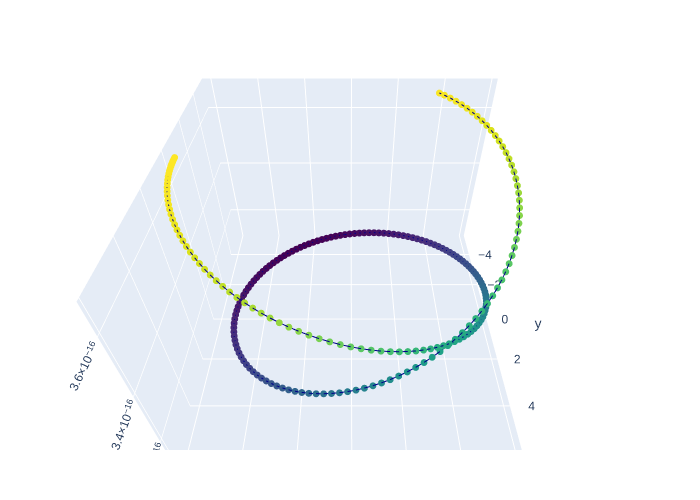

In [159]:
# layout = Layout(
#     width=800,
#     height=700,
#     autosize=false,
#     scene=attr(
#         camera=attr(
#             up=attr(x=0, y=0, z=1),
#             eye=attr(x=0, y=1.0707, z=1)
#         ),
#         aspectratio=attr(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     )
# )
# PlotlyJS.plot(PlotlyJS.scatter(
#         x=getindex.(xcorbit, 1),
#         y=getindex.(xcorbit, 2),
#         z=getindex.(xcorbit, 3),
#         marker=attr(size=4, color=getindex.(xcorbit, 3), colorscale="Viridis"),
#         line=attr(color="darkblue", width=2),
#         type="scatter3d",
#         mode="lines+markers"
#     ), layout)

In [130]:
M = 1e0
m = 1e-6
S = 1.0 * m * M
E = 0.9328* m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = pi / 2
phi0 = 0.0
a0 = 0.8

S1 = 1e-1*m
S2 = 1e-1*m

P1 = 1e-1*m*1.5

1.5e-7

In [131]:
@vars p0 p2 p3 s0 s3

(p0, p2, p3, s0, s3)

In [132]:
gpi= [p0,P1,p2,p3]
gsi= [s0, S1, S2, s3]

4-element Vector{Basic}:
    s0
 1e-07
 1e-07
    s3

In [133]:
# Definitions
Delta = a0^2 - 2 * M * r0 + r0^2
scA = (r0^2 + a0^2)^2 - Delta * a0^2 * sin(theta0)^2
omega_k = 2 * M * a0 * r0 / scA
Sigma = r0^2 + a0^2 * cos(theta0)^2


36.0

In [134]:
Sab= spin_matrix(gsi, gpi, eta , epsl);
display(Sab)

4×4 Matrix{Basic}:
                           0  …    0.5*(-1.5e-14 + 1e-07*p2)
 0.5*(-1e-07*p3 + 1.0*p2*s3)     0.5*(-1e-07*p0 + 1.0*p2*s0)
 0.5*(1e-07*p3 - 1.5e-07*s3)     0.5*(1e-07*p0 - 1.5e-07*s0)
    0.5*(1.5e-14 - 1e-07*p2)                               0

In [135]:
eq210a = (
    sqrt(Delta / Sigma) * gpi[1]
    + a0 / sqrt(Sigma) * sin(theta0) * gpi[4]
    + M / Sigma^2 * (r0^2 - a0^2 * cos(theta0)^2) * Sab[2, 1]
    + 2 * M * r0 * a0 * cos(theta0) / Sigma^2 * Sab[3, 4]
    -
    E
)


-9.328e-07 + 0.82731157639939*p0 + 0.133333333333333*p3 + 2.26786444286547e-19*(1e-07*p0 - 1.5e-07*s0) + 0.0138888888888889*(-1e-07*p3 + 1.0*p2*s3)

In [136]:
expand(eq210a)

-9.328e-07 + 0.82731157639939*p0 + 0.133333331944444*p3 - 3.4017966642982e-26*s0 + 0.0138888888888889*p2*s3

In [137]:
eq210b = (
    a0 * sin(theta0)^2 * sqrt(Delta / Sigma) * gpi[1]
    + (r0^2 + a0^2) * sin(theta0) / sqrt(Sigma) * gpi[4]
    + a0
      *
      ((r0 - M) * Sigma + 2 * M * r0^2)
      /
      Sigma^2
      * sin(theta0)^2
      * Sab[2, 1]
    + a0 * sqrt(Delta) * sin(theta0) * cos(theta0) * Sab[3, 1] / Sigma
    + ((r0^2 + a0^2)^2 - a0^2 * Delta * sin(theta0)^2)
      * cos(theta0)
      * Sab[3, 4]
      /
      Sigma^2
    + r0 * sqrt(Delta) * sin(theta0) * Sab[2, 4] / Sigma
    -
    Jz
)


-2.8e-06 + 0.661849261119512*p0 + 6.10666666666667*p3 + 0.413655788199695*(-1e-07*p0 + 1.0*p2*s0) + 3.13418866004008e-17*(1e-07*p0 - 1.5e-07*s0) + 0.0777777777777778*(-1e-07*p3 + 1.0*p2*s3) + 3.37721491311688e-18*(1e-07*p3 - 1.5e-07*s3)

In [138]:
eq533 = get_norm(gpi, eta)[1] + m^2

1.0225e-12 - 1.0*p0^2 + 1.0*p2^2 + 1.0*p3^2

In [139]:
# eq229 = ein"ij,j,i->"(eta, gpi, gsi)
@tensor begin
    eq229[]:=eta[i,j]*gpi[j]*gsi[i]
end

0-dimensional Array{Basic, 0}:
1.5e-14 + 1e-07*p2 - 1.0*p0*s0 + 1.0*p3*s3

In [140]:
# eq228= ein"ij,j,i->"(eta,gsi,gsi)[1]-S^2
@tensor begin
    eq228[]:=eta[i,j]*gsi[j]*gsi[i]
end
eq228=eq228[1]-S^2

-9.8e-13 - 1.0*s0^2 + 1.0*s3^2

In [141]:
eq210b

-2.8e-06 + 0.661849261119512*p0 + 6.10666666666667*p3 + 0.413655788199695*(-1e-07*p0 + 1.0*p2*s0) + 3.13418866004008e-17*(1e-07*p0 - 1.5e-07*s0) + 0.0777777777777778*(-1e-07*p3 + 1.0*p2*s3) + 3.37721491311688e-18*(1e-07*p3 - 1.5e-07*s3)

In [142]:
eq210a

-9.328e-07 + 0.82731157639939*p0 + 0.133333333333333*p3 + 2.26786444286547e-19*(1e-07*p0 - 1.5e-07*s0) + 0.0138888888888889*(-1e-07*p3 + 1.0*p2*s3)

In [143]:
feq210a=lambdify(eq210a,[p0,p2,p3,s0,s3])

#36 (generic function with 1 method)

In [144]:
feq210b = lambdify(eq210b, [p0, p2, p3, s0, s3])

#36 (generic function with 1 method)

In [145]:
feq228 = lambdify(eq228, [p0, p2, p3, s0, s3])

#36 (generic function with 1 method)

In [146]:
feq229 = lambdify(eq229[1], [p0, p2, p3, s0, s3])

#36 (generic function with 1 method)

In [147]:
feq533 = lambdify(eq533, [p0, p2, p3, s0, s3])

#36 (generic function with 1 method)

In [148]:
function solve_eq(p)
    [feq210a(p[1], p[2], p[3],p[4],p[5]),
        feq210b(p[1], p[2], p[3],p[4],p[5]),
        feq533(p[1], p[2], p[3],p[4],p[5]),
        feq228(p[1], p[2], p[3], p[4], p[5]),
        feq229(p[1], p[2], p[3], p[4], p[5])]

end

solve_eq (generic function with 1 method)

In [149]:
solve_eq([m,m,m,m,m])

5-element Vector{Float64}:
  2.7844922232723868e-8
  3.968516370076388e-6
  2.0225000000000003e-12
 -9.8e-13
  1.1500000000000001e-13

In [150]:
root=nlsolve(solve_eq,[m,m,m,m,m],ftol=1e-12,iterations=100000)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6]
 * Zero: [1.0723419278503233e-6, -3.760718558101123e-7, 3.422933500759042e-7, 3.420821755098372e-7, 1.137726589428054e-6]
 * Inf-norm of residuals: 0.000000
 * Iterations: 39
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-12: true
 * Function Calls (f): 37
 * Jacobian Calls (df/dx): 21

In [151]:
solve_eq(root.zero)

5-element Vector{Float64}:
 -2.305537602702941e-15
 -2.976924228772961e-14
  1.3117756801289934e-13
  1.9740157749004848e-13
  6.152987328366119e-22

In [152]:
p0,p2,p3,s0,s3=root.zero

5-element Vector{Float64}:
  1.0723419278503233e-6
 -3.760718558101123e-7
  3.422933500759042e-7
  3.420821755098372e-7
  1.137726589428054e-6

In [153]:
ngpi=[p0,P1,p2,p3]
ngsi=[s0,S1,S2,s3]

4-element Vector{Float64}:
 3.420821755098372e-7
 1.0e-7
 1.0e-7
 1.137726589428054e-6

In [154]:
get_norm(ngpi,eta)

0-dimensional Array{Float64, 0}:
-8.688224319871005e-13

In [155]:
get_norm(ngsi,eta)

0-dimensional Array{Float64, 0}:
1.1974015774900485e-12

In [156]:
p_coordu=co_tat(r0,theta0,a0,ngpi,"from")

4-element Vector{Float64}:
  1.3648588794869851e-6
  1.2409673645990855e-7
 -6.267864263501871e-8
  8.58528167042853e-8

In [157]:
get_norm(p_coordu,gk)

0-dimensional Array{ComplexF64, 0}:
-8.688224319871004e-13 + 0.0im

In [158]:
s_coordu=co_tat(r0,theta0,a0,ngsi,"from")

4-element Vector{Float64}:
 5.725342587743772e-7
 8.273115763993904e-8
 1.6666666666666664e-8
 1.9880968732499523e-7

In [159]:
get_norm(s_coordu,gk)

0-dimensional Array{ComplexF64, 0}:
1.1974015774900485e-12 + 0.0im

In [160]:
vmu0 = rhs27([0.0, r0, theta0, phi0], p_coordu / m, s_coordu, gk, epsl, a0, m, "u", M)

4-element Vector{ComplexF64}:
   1.3648531811794693 + 0.0im
  0.12409637525402595 + 0.0im
 -0.06267931356733726 + 0.0im
  0.08585253362225033 + 0.0im

In [161]:
y0 = [0.0, r0, theta0, phi0, p_coordu[1], p_coordu[2], p_coordu[3], p_coordu[4], s_coordu[1], s_coordu[2], s_coordu[3], s_coordu[4]];

In [162]:
y0

12-element Vector{Float64}:
  0.0
  6.0
  1.5707963267948966
  0.0
  1.3648588794869851e-6
  1.2409673645990855e-7
 -6.267864263501871e-8
  8.58528167042853e-8
  5.725342587743772e-7
  8.273115763993904e-8
  1.6666666666666664e-8
  1.9880968732499523e-7

In [163]:
get_constants(y0, eta, gk, a0, M)

(9.327999976944621e-7, 2.7999999702307576e-6, -8.688224319871001e-13, 1.1974015774900485e-12)

In [164]:
p = [a0, m, M,0]

4-element Vector{Float64}:
 0.8
 1.0e-6
 1.0
 0.0

In [165]:
t = range(0.,step=1,stop=100000);
t_span = (0, last(t))

(0, 100000.0)

In [166]:
f! = ODEFunction(mpd!);
prob = ODEProblem(mpd!, y0, t_span, p);
saveat=1.0

1.0

In [167]:
# Define the callback function for the Poincaré section
# function poincare_condition(u, t, integrator)
#     # return abs(u[4] % pi - 1)  # Poincaré section at z = 15.0
#     gk=metric_tensor(u[2],u[3],a0,M)
#     velocity=rhs27(u[1:4],u[5:8]./m,u[9:12],gk,epsl,a0,m,"u",M)
#     return velocity[3]-pi/2
# end

# function poincare_callback!(integrator)
#     append!(integrator.u_saved, copy(integrator.u))
# end

In [168]:
# # Define the callback
poincare(u, t, integrator) = u[3]-pi/2 # Trigger when the second component becomes zero
affect!(integrator) = integrator.u[3] = pi/2  # Reset the second component to itself
cb = ContinuousCallback(poincare, affect!,save_positions=(true,true));

In [169]:
# Create the callback function
# cb = DiscreteCallback(poincare_condition, poincare_callback!)

In [170]:
sol = solve(prob, callback=cb,reltol=1e-11, abstol=1e-11, maxiters=1e6);

ArgumentError: ArgumentError: matrix contains Infs or NaNs

In [102]:
sol.u

237-element Vector{Vector{Float64}}:
 [0.0, 6.0, 1.5707963267948966, 0.0, 1.3648588704153787e-6, 0.0, 0.0, 8.585278830601289e-8, 0.0, 0.0, -1.6666666666666665e-7, 0.0]
 [0.0058100349727561364, 5.999999985902045, 1.5707963267948966, 0.00036546714640281594, 1.3648588717650294e-6, -6.623617831225943e-12, 1.6008550432750389e-27, 8.585278873188508e-8, -3.590218866838504e-28, 3.129205664063055e-31, -1.666666670582779e-7, 3.311016302218532e-27]
 [0.014483890662584181, 5.999999912386891, 1.5707963267948966, 0.0009110764824360147, 1.3648588788029135e-6, -1.651207833873972e-11, 3.990786671612872e-27, 8.585279095263702e-8, -8.950093584625282e-28, 1.944675230112758e-30, -1.6666666910037283e-7, 8.254063649962957e-27]
 [0.02956216628729437, 5.999999635018301, 1.5707963267948966, 0.0018595414590730631, 1.3648589053564613e-6, -3.370176862734126e-11, 8.145346835633077e-27, 8.585279933141147e-8, -1.8267503522074676e-27, 8.10119507733385e-30, -1.66666676805084e-7, 1.6846855237913378e-26]
 [0.048977714230

In [103]:
poi_points = filter(x -> abs(x[3]-pi/2)<1e-10 , sol.u);

In [104]:
length(poi_points)

237

In [105]:
vr= zeros(length(poi_points));

In [106]:
for i in range(1,length(vr))
    gk=metric_tensor(poi_points[i][2],poi_points[i][3],a0,M)
    vr[i] = rhs27(poi_points[i][1:4],poi_points[i][5:8]/m,poi_points[1][9:12],gk,levi_cevita_tensor(4),a0,m,"u",M)[2]

end

In [107]:
r = [v[2] for v in poi_points];
# vr = [v[6] for v in poi_points];

237-element Vector{Float64}:
 6.0
 5.999999985902045
 5.999999912386891
 5.999999635018301
 5.999998998166574
 5.999997857139457
 5.999995307804477
 5.999991284710262
 5.999982840608991
 5.999970437895536
 ⋮
 5.961130461124475
 5.966929067828149
 5.972284032230796
 5.977188434625829
 5.981633220222122
 5.985612797871288
 5.989118841011562
 5.992146282763767
 5.994282966063175

In [108]:
corbit=map(x->to_cartesian(x),sol.u);
xcorbit = [corbit[i][1] for i in 1:length(corbit)];

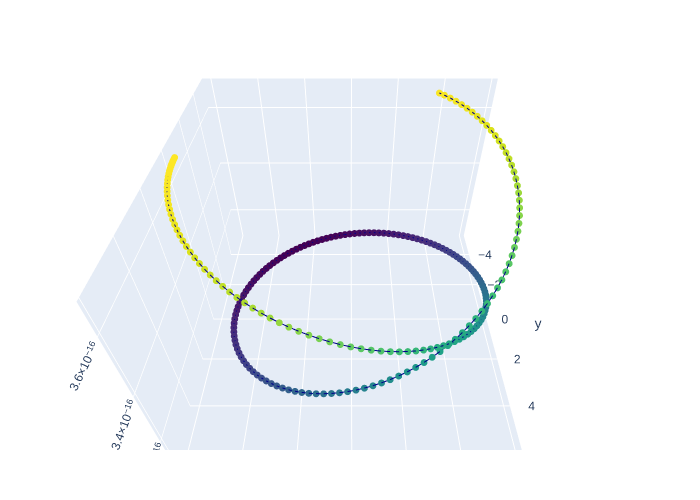

In [160]:
# layout = Layout(
#     width=800,
#     height=700,
#     autosize=false,
#     scene=attr(
#         camera=attr(
#             up=attr(x=0, y=0, z=1),
#             eye=attr(x=0, y=1.0707, z=1)
#         ),
#         aspectratio=attr(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     )
# )
# PlotlyJS.plot(PlotlyJS.scatter(
#         x=getindex.(xcorbit, 1),
#         y=getindex.(xcorbit, 2),
#         z=getindex.(xcorbit, 3),
#         marker=attr(size=4, color=getindex.(xcorbit, 3), colorscale="Viridis"),
#         line=attr(color="darkblue", width=2),
#         type="scatter3d",
#         mode="lines+markers"
#     ), layout)

In [110]:
energy = map(x -> get_constants(x, eta, metric_tensor(x[1], x[2], a0, M), a0, M), sol.u);

In [111]:
@show ΔE = energy[1][2] - energy[end][2]

ΔE = (energy[1])[2] - (energy[end])[2] = 5.833900172707218e-13


5.833900172707218e-13

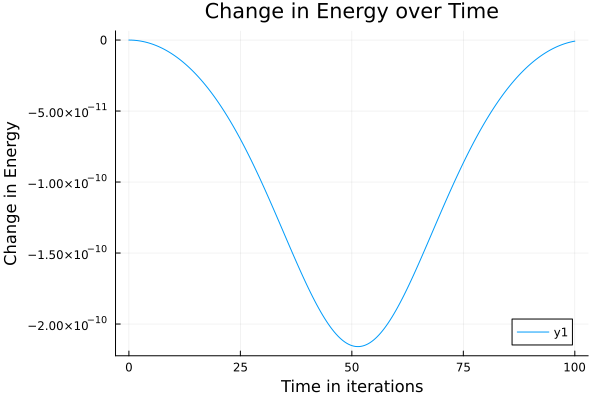

In [112]:
#Plot
Plots.plot(sol.t, [energy[i][1] - energy[1][1] for i in range(1, length(sol.u))], title="Change in Energy over Time",
    xaxis="Time in iterations", yaxis="Change in Energy")

In [113]:
# PlotlyJS.plot(PlotlyJS.scatter(x=getindex.(poi_points, 2), y=vr, mode="markers"))

In [114]:
theta_poi=[poi_points[i][3] for i in range(1,length(poi_points))];

In [115]:
minimum(theta_poi.-pi/2)

0.0

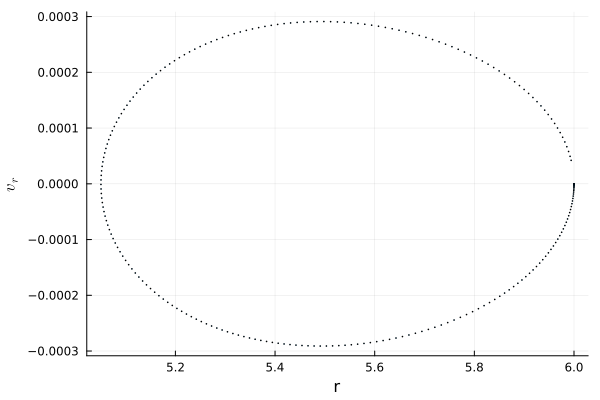

In [116]:
Plots.plot(getindex.(poi_points,2),vr, seriestype=:scatter, ms=0.5, legend=false)
xlabel!("r")
ylabel!(L"v_r")
# title!(latexstring("\\mathrm{Poincare\\, \\, Plot\\, \\, when\\, theta=pi/2\\, Energy=0.9328e-4, Jz=2.8e-4, S=1e-4}"))
# Plots.savefig("Poincare_Plot_julia.png")
# Add a title with LaTeX
# title!(latexstring("\\mathrm{Poincare\\, \\, Plot\\, \\, when\\, z=0\\, and\\, v_z>0\\,}"))

In [117]:
@vars dp0,dp2,ds0

(dp0, dp2, ds0)

In [118]:
EPS=1e-12

1.0e-12

In [119]:
rng = MersenneTwister(1234);

In [120]:
dy0=[0;randn(1);randn(1);randn(1);dp0/EPS;randn(1);dp2/EPS;randn(1);ds0/EPS;randn(1);randn(1);randn(1)].*EPS

12-element Vector{Basic}:
                     0
   1.7468017771277e-13
 -2.76970449274483e-13
 -3.15119451006661e-13
               1.0*dp0
  1.84474616961782e-13
               1.0*dp2
 -1.21174329849943e-12
               1.0*ds0
  4.75879024923382e-13
  6.05982150230791e-13
  -2.0058231288067e-13

In [121]:
y0

12-element Vector{Float64}:
 0.0
 6.0
 1.5707963267948966
 0.0
 0.00013648585223970163
 1.2409673645990858e-5
 1.6874634471898887e-6
 8.585293972800816e-6
 5.828642169044241e-5
 8.273115763993906e-6
 1.6666666666666667e-6
 1.8520355966159542e-5

In [122]:
ry0 = dy0 .+ y0

12-element Vector{Basic}:
                              0
               6.00000000000017
               1.57079632679462
          -3.15119451006661e-13
 0.000136485852239702 + 1.0*dp0
           1.24096738304655e-05
 1.68746344718989e-06 + 1.0*dp2
           8.58529276105752e-06
 5.82864216904424e-05 + 1.0*ds0
           8.27311623987293e-06
           1.66666727264882e-06
           1.85203557655772e-05

In [123]:
eqC1=expand(get_norm(ry0[5:8],gk)[1]+m^2)

1.84456502096286e-13 - 0.000186477544117145*dp0 + 0.000121265943646319*dp2 - 0.666348750747493*dp0^2 + 35.9314282772351*dp2^2

In [124]:
eqC2= expand(get_norm(ry0[9:end],gk)[1]-S^2)

-2.28400739870196e-11 - 8.75651122983929e-05*ds0 - 0.666348750747493*ds0^2

In [125]:
@tensor begin
    eqC3[]:= gk[i,j]*ry0[5:8][j]*ry0[9:end][i]
end
eqC3=expand(eqC3[1])

-9.24319876449496e-12 - 4.37825561491965e-05*dp0 + 5.98857355691961e-05*dp2 - 9.32387720585724e-05*ds0 - 0.666348750747493*ds0*dp0

In [126]:
feqC1=lambdify(eqC1,[dp0,dp2,ds0])

#36 (generic function with 1 method)

In [127]:
feqC2= lambdify(eqC2,[dp0,dp2,ds0])

#36 (generic function with 1 method)

In [128]:
feqC3= lambdify(eqC3,[dp0,dp2,ds0])

#36 (generic function with 1 method)

In [129]:
function const_sol_eq(p)
    [feqC1(p[1],p[2],p[3]),feqC2(p[1],p[2],p[3]),feqC3(p[1],p[2],p[3])]
end

const_sol_eq (generic function with 1 method)

In [130]:
const_sol=nlsolve(const_sol_eq,[m,m,m],ftol=1e-10)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0001, 0.0001, 0.0001]
 * Zero: [6.587074216814477e-6, 4.54409635216765e-6, -2.6135511431955606e-7]
 * Inf-norm of residuals: 0.000000
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-10: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 7

In [131]:
dp0,dp2,ds0=const_sol.zero

3-element Vector{Float64}:
  6.587074216814477e-6
  4.54409635216765e-6
 -2.6135511431955606e-7

In [132]:
dy0[5]= dp0
dy0[7]= dp2
dy0[9]= ds0

-2.6135511431955606e-7

In [133]:
dy0

12-element Vector{Basic}:
                     0
   1.7468017771277e-13
 -2.76970449274483e-13
 -3.15119451006661e-13
  6.58707421681448e-06
  1.84474616961782e-13
  4.54409635216765e-06
 -1.21174329849943e-12
 -2.61355114319556e-07
  4.75879024923382e-13
  6.05982150230791e-13
  -2.0058231288067e-13

In [134]:
ry0=Float64.(dy0.+y0)

12-element Vector{Float64}:
  0.0
  6.000000000000175
  1.5707963267946197
 -3.151194510066615e-13
  0.0001430729264565161
  1.2409673830465476e-5
  6.2315597993575395e-6
  8.585292761057518e-6
  5.802506657612285e-5
  8.273116239872932e-6
  1.6666672726488168e-6
  1.852035576557723e-5

In [135]:
function evolve_lyap2(y0, y1)
    ti = 0.0
    tf = last(t_span)
    tau = 1000
    timestep = LinRange(ti, tf, tau)
    li = zeros(length(timestep) - 1)
    EPS = 1e-6
    p=[a0,m,M,0]

    for i in 1:length(timestep) - 1
        tspan = (timestep[i], timestep[i+1])
        # f != ODEFunction(mpd!)
        prob = ODEProblem(mpd!, y0, tspan, p)
        soly0 = solve(prob, reltol=1e-11, abstol=1e-11, maxiters=1e6)

        prob = ODEProblem(mpd!, ry0, tspan, p)
        soly1 = solve(prob, reltol=1e-10, abstol=1e-8, maxiters=1e6)

        v1 = (soly1.u[end] .- soly0.u[end]) ./ norm(soly1.u[end] .- soly0.u[end])

        li[i] = log(norm(soly1.u[end] .- soly0.u[end]) / EPS) / tau

        y0 = soly0.u[end]
        y1 = y0 .+ EPS .* v1

    end

    return li
    

end

evolve_lyap2 (generic function with 1 method)

In [136]:
# lis= evolve_lyap2(y0,ry0);

In [137]:
# Statistics.mean(lis)

In [138]:
# Plots.plot(LinRange(ti, tf, tau)[1:end-1],lis,title="Lyapunov Exponent",
# xaxis="Time",yaxis="Magnitude")

In [139]:
cy0=ComplexF64.(y0)

12-element Vector{ComplexF64}:
                    0.0 + 0.0im
                    6.0 + 0.0im
     1.5707963267948966 + 0.0im
                    0.0 + 0.0im
 0.00013648585223970163 + 0.0im
  1.2409673645990858e-5 + 0.0im
  1.6874634471898887e-6 + 0.0im
   8.585293972800816e-6 + 0.0im
   5.828642169044241e-5 + 0.0im
   8.273115763993906e-6 + 0.0im
  1.6666666666666667e-6 + 0.0im
  1.8520355966159542e-5 + 0.0im

In [140]:
size(cy0)

(12,)

In [141]:
H=diagm(ones(ComplexF64,size(cy0))).*2e-16;

In [142]:
function fjac(f, x, args...)
    fx = f(0, x, args...)
    n = length(fx)
    J = zeros(Complex, n, n)
    H = I * sqrt(eps()) * (1 .+ abs.(x))

    for i in 1:n
        J[:, i] = imag(f(0, x + H[i], args...)) / imag(H[i, i])
    end

    return J
end

fjac (generic function with 1 method)

In [ ]:
metric_tensor

In [149]:
dy=zeros(length(y0))

12-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [154]:
mpd(0,y0,p)

12-element Vector{Float64}:
   1.364853706585847
   0.12409646306028813
   0.01687471041358157
   0.08585262163374613
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [151]:
mpd!(dy,y0,p,0)

In [156]:
fjac(mpd!,y0,p)

MethodError: MethodError: no method matching mpd!(::Int64, ::Vector{Float64}, ::Vector{Float64})

Closest candidates are:
  mpd!(::Any, ::Any, ::Any, !Matched::Any)
   @ Main ~/GWProject/Einsteinpy_julia.ipynb:1
